# *checkpoint_schedule* application: adjoint-based gradient with Burger's equation
This notebook aims to present the usage of the `checkpoint_schedules` package in an adjoint-based sensitivity problem. We begin by defining the adjoint-based gradient problem

### Defining the application
Let us consider a one-dimensional (1D) problem where it aims to compute the gradient/sensitivity of an objective functional $I$  with respect to a control parameter. In the current case, consider the initial condition $u_0$ as the control parameter, and the objective functional given by:
$$
I(u) = \int_{\Omega} E(u(\tau)) \, d x
\tag{1}
$$
The objective functional $I(u)$ and $E (u (t)) = 0.5 \, u(x, t)u(x, t)$ is the kinetic energy, where $t \in \mathbb{R}^{+}$ represents the time variable. The velocity variable $u = u(x, t)$ is governed by the 1D viscous Burgers equation, a nonlinear equation for the advection and diffusion on momentum:
$$
\frac{\partial u}{\partial t} + u \frac{\partial u}{\partial x} - \nu \frac{\partial^2 u}{\partial x^2} = 0
\tag{2},
$$
where $x \in [0, L]$ is the space variable. The boundary condition is $u(0, t) = u(L, t) = 0$, where $L$ represents the lenght of the 1D domain. The initial condition is here given by $u(0, t) = u_0 = \sin(\pi x)$.

In this current case, we aims to measure the sensitivity of the kinetic energy $E(u)$ with respect to the initial condition $u_0$ using the adjoint-based gradient method. Therefore, we need initially to define the adjoint-based gradient expression that is here set by using the continuous formulation, which means the sensitivity is obtained from the continuous forward PDE (Partial Differential Equation). In this case, let us consider an augmented functional $J$ given by:
$$J(u, \lambda, u_0, \alpha) = I(u) - \int_{0}^{\tau} \int_{\Omega}  \lambda \left( \frac{\partial u}{\partial t} + u \frac{\partial u}{\partial x} - \nu \frac{\partial^2 u}{\partial x^2} \right)\, d x \, d t, $$
where $\alpha$ and $\lambda$ are the Lagrange multipliers also referred to as the adjoint variables. The adjoint-based gradient expression is obtained by applying the differentiation of the augmented functional $J$ with respect to the initial condition $u_0$, which results in:
$$ \frac{\partial E}{\partial u_0} = - \lambda(x, 0) \tag{3}$$
Notice that the gradient expression depends of the Lagrange multiplier $\lambda$, which is obtained by solving an adjoint equation. The adjoint equation is obtained by applying the differentiation of the augmented functional $J$ with respect to the velocity variable $u$, which results in:
$$
-\frac{\partial \lambda}{\partial t} + \lambda\frac{\partial u}{\partial x} - u \frac{\partial \lambda}{\partial x} - \nu \frac{\partial^2 \lambda}{\partial x^2} = 0,
\tag{4}
$$
satisfying the boundary condition $\lambda (0, t) = \lambda(L, t) = 0$. In this case, the initial condition is $\lambda (x, \tau) = u(x, \tau)$.

Notice that the initial condition of the adjoint equation is at the time $\tau$ that is the final time of the forward  Burgers equation. In addition, the sensitivity expression (3) depends of the adjoint variable at the final adjoint time $t=0$. Therefore, compute the adjoint-based gradient requires storing the forward solution for each time-step, since the adjoint equation depends on the forward solution as seen in adjoint equation (4). Additionally, the gradient expression (3) is a function of $\lambda (0, t)$.

#### Burger's equation discretisation
Both the forward and adjoint systems are discretised using the Finite Element Method (FEM), employing a discretisation methodology detailed in [1]. This methodology uses the Galerkin Continuous method with linear trial basis functions to obtain an approximate solution. The backward finite difference method is employed to discretise the equations in time.

#### Coding

As the previous example, we use the `CheckpointingManager` class intending to manage the execution of forward and adjoint models using a checkpointing schedule. The `CheckpointingManager` has the method `execute` that executes every single action given the checkpointing schedule by iterating over the elements of the `cp_schedule`. Inside the `execute` method, we have the `action` function, which is a single-dispatch generic function. The `action` function is overloaded by the `action_forward`, `action_adjoint`, `action_copy`, `action_move`, `action_end_forward` and `action_end_reverse` according to the actions reached by the iterations over the elements of the `cp_schedule`, e.g., if the action is `Forward`, then the `action_forward` function is called and inside this function, we can implement the necessary code to advance the forward equation. In this current example, we execute the forward solver by calling `self.equation.forward`. Notice that the `self.equation` is an attribute of `CheckpointingManager`. Thus, this attribute would have a `forward` method that executes the forward solver. In addition, in `action_copy` and `action_move`, we add the `self.equation.copy_data`, ...

In [398]:
import functools, sys
from checkpoint_schedules import *

class CheckpointingManager:
    """Manage the forward and backward solvers.

    Attributes
    ----------
    schedule : CheckpointSchedule
        The schedule created by `checkpoint_schedules` package.
    equation : object
        An equation object used to solve the forward and adjoint solvers.
    
    Notes
    -----
    The `equation` object must have the following methods: `forward`, `adjoint`, `adjoint_initial_condition`, `copy_data`.
    The forward and adjoint methods execute the forward and adjoint solvers, respectively. The `adjoint_initial_condition`
    method is used to compute the initial condition for the adjoint solver. The copy_data method is used to copy data
    from one storage to another.
    """
    def __init__(self, schedule, equation):
        self.max_n = sys.maxsize
        self.equation = equation
        self.reverse_step = 0
        self._schedule = schedule
        
    def execute(self):
        """Execute forward and adjoint using checkpointing.
        """
        @functools.singledispatch
        def action(cp_action):
            raise TypeError("Unexpected action")

        @action.register(Forward)
        def action_forward(cp_action):
            n1 = cp_action.n1
            if (
                isinstance(self._schedule, SingleMemoryStorageSchedule) 
                or isinstance(self._schedule, SingleDiskStorageSchedule)
            ): 
                self.equation.forward(cp_action.n0, n1, storage=cp_action.storage,
                                      single_storage=True, write_adj_deps=cp_action.write_adj_deps)
            else:    
                self.equation.forward(cp_action.n0, n1, storage=cp_action.storage,
                                      write_adj_deps=cp_action.write_adj_deps, write_ics=cp_action.write_ics)
            if n1 > self.equation.model["max_n"]:
                n1 = min(n1, self.equation.model["max_n"])
                self._schedule.finalize(n1)
            

        @action.register(Reverse)
        def action_reverse(cp_action):
            if self.reverse_step == 0:
                self.equation.adjoint_initial_condition()
            self.equation.adjoint(cp_action.n0, cp_action.n1, cp_action.clear_adj_deps)
            self.reverse_step += cp_action.n1 - cp_action.n0
            
        @action.register(Copy)
        def action_copy(cp_action):
            self.equation.copy_data(cp_action.n, cp_action.from_storage, cp_action.to_storage)

        @action.register(Move)
        def action_move(cp_action):
            self.equation.copy_data(cp_action.n, cp_action.from_storage, cp_action.to_storage, move=True)
            
        @action.register(EndForward)
        def action_end_forward(cp_action):
            if self._schedule.max_n is None:
                self._schedule._max_n = self.max_n
            assert self.reverse_step == 0
            
        @action.register(EndReverse)
        def action_end_reverse(cp_action):
            if self._schedule.max_n != self.reverse_step:
                raise ValueError("The number of steps in the reverse phase"
                                 "is different from the number of steps in the"
                                 "forward phase.")
            
        self.reverse_step = 0
        for _, cp_action in enumerate(self._schedule):
            action(cp_action)
            if isinstance(cp_action, EndReverse):
                break


As we sad, the `CheckpointingManager` class has the `execute` method that executes every single action given the checkpointing schedule by iterating over the elements of the `cp_schedule`. To do so, we need to provide the equation. Here, we are handling with a adjoint-based sensitivity problem with Burger's equation. Thus, we need to provide the `BurgersEquation` class. The `BurgersEquation` class has the `forward` and `adjoint` methods that execute the forward and adjoint solvers, respectively. In addition, the `BurgersEquation` class has the `copy_data` and `adjoint_initial_condition` methods that copy the data from the forward solver to the adjoint solver and set the adjoint initial condition, respectively. The code is an implmentation  of the `BurgersEquation` with the methods required by solving the adjoint-based sensitivity problem using the checkpointing manager class `CheckpointingManager`.

In [399]:
import numpy as np
from enum import Enum
import os
from scipy.sparse.linalg import spsolve
from scipy.sparse import lil_matrix
from scipy.optimize import newton


class BurgersEquation:
    """This class is capable to solve the time-dependent forward 
    and adjoint burger's equation.

    Attributes
    ----------
    model : dict
        The model parameters containing the essential information to solve
        the burger's equation.
    init_condition : array
        The initial condition used to solve the forward burger's equation.
    """
    def __init__(self, model, forward_init_condition):
        self.model = model
        self.snapshots = {StorageType.RAM: {}, StorageType.DISK: {}}
        self.forward_work_memory = {StorageType.WORK: {}}
        self.forward_init_condition = forward_init_condition
        self.forward_final_solution = None
        self.forward_work_memory[StorageType.WORK][0] = forward_init_condition
        self.adjoint_work_memory = {StorageType.WORK: {}}
            
    def forward(
            self, n0, n1, storage=None, write_adj_deps=False,
            write_ics=False, single_storage=False
    ):
        """Solve the non-linear forward burger's equation in time.

        Parameters
        ----------
        n0 : int
            Initial time step.
        n1 : int
            Final time step.
        storage : StorageType, optional
            The storage type, which can be StorageType.RAM, StorageType.DISK,
            StorageType.WORK, or StorageType.NONE.
        write_adj_deps : bool, optional
            Whether the adjoint dependency data will be stored.
        write_ics : bool, optional
            Whether the forward restart data will be stored.
        single_storage : bool, optional
            This parameter is used to indicated whether a checkpointing schedule
            is single storage or not. Single storage means that no checkpointing
            algorithm (eg, `Revolve`, `HRevole`) is employed. 
        """
        # Get the model parameters
        dx = self.model["lx"] / self.model["nx"]  # grid spacing
        nx = self.model["nx"]  # number of grid points
        dt = self.model["dt"]  # time step
        nu = self.model["nu"]  # viscosity
        b = nu / (dx * dx)

        def assemble_matrix_system(u_new):
            """This function assembles the matrix system.

            Parameters
            ----------
            u_new : array
                Forward solution at the n + 1 time step.

            Returns
            -------
            A , B : scipy.sparse.lil_matrix
                Matrix systems.
            """
            A = lil_matrix((nx, nx))
            B = lil_matrix((nx, nx))  # mass matrix
            B[0, 0] = - 1 / 3
            B[0, 1] = - 1 / 6
            B[nx - 1, nx - 1] = - 1 / 3
            B[nx - 1, nx - 2] = - 1 / 6
            A[0, 0] = 1 / 3 - dt * (1/2*u_new[0] / dx + b)
            A[0, 1] = 1 / 6 + dt * (1 / 2 * u_new[0] / dx - b)
            A[nx - 1, nx - 1] = 1 / 3 - dt * (- u_new[nx - 1] / dx + b)
            A[nx - 1, nx - 2] = 1 / 6 + dt * (1 / 2 * u_new[nx - 2] / dx - b)

            for i in range(1, nx - 1):
                B[i, i] = - 2 / 3
                B[i, i + 1] = B[i, i - 1] = - 1 / 6
                A[i, i - 1] = 1 / 6 - dt * (1 / 2 * u_new[i - 1] / dx + b)
                A[i, i] = 2 / 3 + dt * (1 / 2 * (u_new[i - 1] - u_new[i]) / dx + 2 * b)
                A[i, i + 1] = 1 / 6 + dt * (1 / 2 * u_new[i] / dx - b)

            return A, B

        def non_linear(A, B, u_new, u):
            """This function computes the non-linear solver.

            Parameters
            ----------
            A : scipy.sparse.lil_matrix
                Matrix system.
            B : scipy.sparse.lil_matrix
                Matrix system.
            u_new : array
                Forward solution at the n + 1 time step.
            u : array
                Forward solution at the n time step.
            """
            # Set the boundary conditions.
            u[0] = u[nx - 1] = 0
            F = A * u_new + B * u
            return F

        # Get the initial condition
        u = self.forward_work_memory[StorageType.WORK][n0]
        if not single_storage:
            del self.forward_work_memory[StorageType.WORK][n0]
        u_new = u.copy()
        n1 = min(n1, self.model["max_n"])
        step = n0
        while step < n1:
            if ((write_ics and step == n0)
                or (write_adj_deps and storage != StorageType.WORK)):
                self._store_data(u, step, storage,
                                write_adj_deps=write_adj_deps,
                                write_ics=write_ics)
            A, B = assemble_matrix_system(u_new)
            u_new = newton(lambda u_new: non_linear(A, B, u_new, u), u)
            u = u_new.copy()
            if single_storage and storage == StorageType.WORK:
                self.forward_work_memory[StorageType.WORK][step] = u_new
            step += 1
        self.forward_work_memory[StorageType.WORK][step] = u_new
        if n1 == self.model["max_n"]:
            self.forward_final_solution = u_new.copy()

    def adjoint(self, n0, n1, clear_adj_deps):
        """Execute the adjoint equation in time.

        Parameters
        ---------
        n0 : int
            Initial time step.
        n1 : int
            Final time step.
        clear_adj_deps : bool
            If `True`, the adjoint dependency data will be cleared.
        """
        dx = self.model["lx"] / self.model["nx"]
        nx = self.model["nx"]
        dt = self.model["dt"]
        nu = self.model["nu"]
        b = nu / (dx * dx)

        def assemble_matrix_system(adjoint_dependency):
            A = lil_matrix((nx, nx))
            B = lil_matrix((nx, nx))
            A[0, 0] = A[nx - 1, nx - 1] = 1 / 3
            A[0, 1] = A[nx - 1, nx - 2] = 1 / 6
            dfdx = (adjoint_dependency[1] - adjoint_dependency[0]) / dx
            dfdxp = (adjoint_dependency[2] - adjoint_dependency[1]) / dx
            B[0, 0] = 1 / 3 - dt * (adjoint_dependency[0] / dx - b - 1 / 3 * dfdx)
            B[0, 1] = (1 / 6 + dt * (1 / 2 * adjoint_dependency[0] / dx + b - 1 / 6 * dfdxp))
            dfdx = (adjoint_dependency[nx - 1] - adjoint_dependency[nx - 2]) / dx
            B[nx - 1, nx - 1] = (1 / 3 + dt * (adjoint_dependency[nx - 1] / dx - b - 1 / 3 * dfdx))
            B[nx - 1, nx - 2] = (1 / 6 + dt * (1 / 2 * u_new[nx - 2] / dx + b - 1 / 6 * dfdx))

            for i in range(1, nx - 1):
                v_m = adjoint_dependency[i] / dx
                v_mm1 = adjoint_dependency[i - 1] / dx
                deri = (adjoint_dependency[i] - adjoint_dependency[i - 1]) / dx
                derip = (adjoint_dependency[i + 1] - adjoint_dependency[i]) / dx
                A[i, i - 1] = A[i, i + 1] = 1 / 6
                A[i, i] = 2 / 3
                B[i, i] = 2 / 3 + dt * (1 / 2 * (v_mm1 - v_m) - 2 * b - 2 / 3 * (deri - derip))
                B[i, i - 1] = 1/6 - dt * (1 / 2 * v_mm1 - b - 1 / 6 * deri)
                B[i, i + 1] = 1/6 + dt*(1/2 * v_m + b - 1 / 6 * derip)
            return A, B

        u = self.adjoint_work_memory[StorageType.WORK][n1]
        del self.adjoint_work_memory[StorageType.WORK][n1]
        u_new = np.zeros(nx)
        steps = n1 - n0
        t = n1
        for _ in range(steps):
            u[0] = u[nx - 1] = 0
            A, B = assemble_matrix_system(self.forward_work_memory[StorageType.WORK][t])
            d = B.dot(u)
            u_new = spsolve(A, d)
            u = u_new.copy()
            if clear_adj_deps:
                del self.forward_work_memory[StorageType.WORK][t]
            t -= 1
        self.adjoint_work_memory[StorageType.WORK][n0] = u_new
    
    def compute_grad(self):
        """Compute the gradient.
        """
        u_adj = self.adjoint_work_memory[StorageType.WORK][0]
        grad = - u_adj
        return grad
    
    def _store_on_disk(self, data, step, adj_deps=False):
        """Store the forward data on disk.

        Parameters
        ----------
        data : array
            The forward data.
        step : int
            The time step.
        adj_deps : bool, optional
            If True, the data is stored in the adjoint dependencies folder.
        """
        if adj_deps:
            file_name = "adj_deps/fwd_"+ str(step) +".npy"
            with open(file_name, "wb") as f:
                np.save(f, data)
        else:
            file_name = "fwd_data/fwd_"+ str(step) +".npy"
            with open(file_name, "wb") as f:
                np.save(f, data)
        self.snapshots[StorageType.DISK][step] = file_name

    def copy_data(self, step, from_storage, to_storage, move=False):
        """Load the forward data from disk.

        Parameters
        ----------
        file_name : str
            The file name.
        step : int
            The time step.

        Returns
        -------
        data : array
            The loaded data.
        """
        if from_storage == StorageType.DISK:
            file_name = self.snapshots[StorageType.DISK][step]
            with open(file_name, "rb") as f:
                if to_storage == StorageType.RAM:
                    self.snapshots[StorageType.RAM][step] = np.load(f)
                elif to_storage == StorageType.WORK:
                    self.forward_work_memory[StorageType.WORK][step] = np.load(f)
                if move:
                    os.remove(file_name)
        elif from_storage == StorageType.RAM:
            self.forward_work_memory[StorageType.WORK][step] = self.snapshots[StorageType.RAM][step]
            if move:
                del self.snapshots[StorageType.RAM][step]

    def _store_data(self, data, t, storage, write_adj_deps=False, write_ics=False):
        """Store the forward data.

        Parameters
        ----------
        data : array
            The forward data.
        t : int
            The time step.
        storage : StorageType
            The storage type.
        write_adj_deps : bool, optional
            If `True`, the adjoint dependency data will be stored.
        write_ics : bool, optional
            If `True`, the forward restart data will be stored.
        """
        if storage == StorageType.DISK:
            if write_adj_deps:
                self._store_on_disk(data, t, adj_deps=write_adj_deps)
            if write_ics:
                self._store_on_disk(data, t)
        elif storage == StorageType.RAM:
            self.snapshots[storage][t] = data


    def adjoint_initial_condition(self):
        """Set the adjoint initial condition.
        """
        u = self.forward_final_solution
        self.adjoint_work_memory[StorageType.WORK][self.model["max_n"]] = u


def kinetic_energy(u):
    """Compute the kinetic energy.

    Parameters
    ----------
    u : array
        The solution.

    Returns
    -------
    ke : float
        The kinetic energy.
    """
    return 0.5 * u**2

def central_finite_difference(u0, u1, dx):
    """Compute the central finite difference.

    Parameters
    ----------
    u0 : numpy.array
        The solution at the n time step.
    u1 : numpy.array
        The solution at the n + 1 time step.
    dx : float
        The grid spacing.

    Returns
    -------
    dfdx : array
        The central finite difference.
    """
    return (u1 - u0) / (2 * dx)

Below, we define the `model` dictionary that contains the parameters required for the forward and adjoint solvers. The `model` dictionary is passed to the `BurgersEquation` class. 

In [400]:
model = {"lx": 1,   # lenght domain
         "nx": 200, # number of nodes
         "dt": 0.001, # time step
         "T": 2, # final time
         "nu": 0.001, # viscosity
         "max_n": 200, # total steps
         "chk_ram": 10, # number of checkpoints in RAM
         "chk_disk": 0, # number of checkpoints on disk
        }

Next, we set the initial condition and the burger's equation object `burger`.

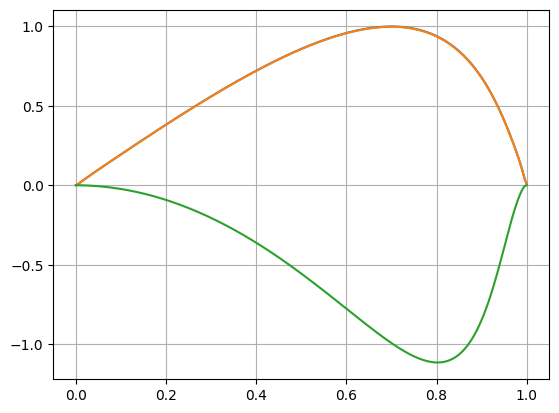

In [401]:
x = np.linspace(0, model["lx"], model["nx"]) # create the spatial grid
u0 = np.sin(np.pi*x) # initial condition
burger = BurgersEquation(model, u0) # create the burger's equation object
burger.forward(0, model["max_n"]) # solve the forward equation
import matplotlib.pyplot as plt
E = kinetic_energy(burger.forward_final_solution) # compute the kinetic energy

u0 = 1.001*np.sin(np.pi*x) # initial condition

burger = BurgersEquation(model, u0) # create the burger's equation object
burger.forward(0, model["max_n"]) # solve the forward equation
u_p = burger.forward_final_solution
E1 = kinetic_energy(u_p) # compute the kinetic energy

u00 = 0.999*np.sin(np.pi*x) # initial condition

burger = BurgersEquation(model, u00) # create the burger's equation object
burger.forward(0, model["max_n"]) # solve the forward equation
u_m = burger.forward_final_solution

plt.show()
E2 = kinetic_energy(u_m) # compute the kinetic energy
du0 = 0.001
dEdu0 = central_finite_difference(E1, E2, du0) # compute the gradient
plt.plot(x, u_p)
plt.plot(x, u_m)
plt.plot(x, dEdu0)
plt.grid()
plt.show()


### Execute a forward simulation
`checkpoint_schedules` package provides a set of checkpointing schedules. The first employed here is `NoneCheckpointingSchedule` that executes only the forward solver without any storage in RAM or on disk. 

In [402]:
u0 = np.sin(np.pi*x) # initial condition
burger = BurgersEquation(model, u0) # create the burger's equation object
schedule = NoneCheckpointSchedule() # create the checkpointing schedule
manager = CheckpointingManager(schedule, burger)  # create the checkpointing manager
manager.execute()  # execute the forward and adjoint solvers using checkpointing

### Execute the adjoint-based gradient

We finally present the adjoint-based gradient computation using differents checkpoints approaches available in the `checkpoint_schedules` package. The first one, it is `SingleMemoryStorageSchedule` for the cases where the user intend to store the forward data for all steps. As we explained in the illustration example, the `SingleMemoryStorageSchedule` schedule does not require the maximal step `model["max_n"]`. Hence, we can define the final forward step while the forward solver is being executed. 

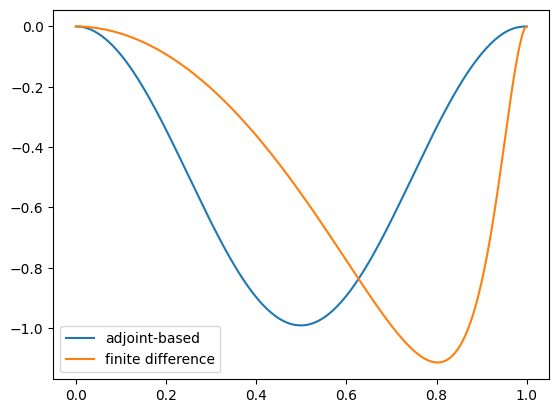

In [403]:
schedule = SingleMemoryStorageSchedule()  # create the checkpointing schedule
burger = BurgersEquation(model, u0) # create the burger's equation object
manager = CheckpointingManager(schedule, burger)  # create the checkpointing manager
manager.execute()  # execute the forward and adjoint solvers using checkpointing
s = burger.compute_grad() # compute the gradient
plt.plot(x, s*np.sin(np.pi*x), label="adjoint-based")
plt.plot(x, dEdu0, label="finite difference")
plt.legend()
plt.show()

The next example shows the usage of the `SingleDiskStorageSchedule` schedule. In this case, the forward data used in the adjoint compuations is stored on disk. The `SingleDiskStorageSchedule` schedule does not require the maximal step `model["max_n"]` to be defined before the forward solver execution.

In [404]:
schedule = SingleDiskStorageSchedule()  # create the checkpointing schedule
burger = BurgersEquation(model, u0) # create the burger's equation object
manager = CheckpointingManager(schedule, burger)  # create the checkpointing manager
manager.execute()  # execute the forward and adjoint solvers using checkpointing
sens = burger.compute_grad() # compute the gradient

With the example above, we do not move any data from the disk to the work in memory, i.e., we copy the data from the disk and keep this data on disk. The next example shows the usage of the `SingleDiskStorageSchedule` schedule with the `mode_data=True` argument. In this case, the forward data used in the adjoint compuations stored on disk is moved to the work in memory, i.e., we copy the data from the disk and remove this data from the disk. 

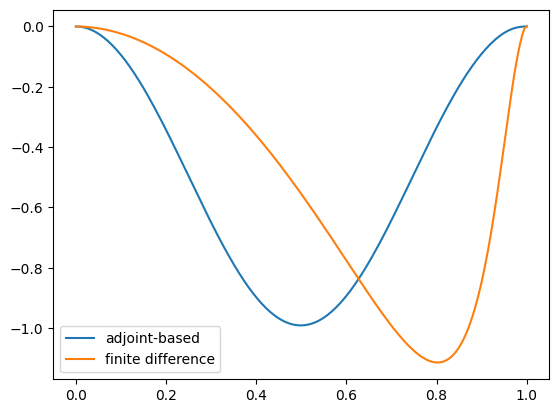

In [405]:
schedule = SingleDiskStorageSchedule(move_data=True)  # create the checkpointing schedule
burger = BurgersEquation(model, u0) # create the burger's equation object
manager = CheckpointingManager(schedule, burger)  # create the checkpointing manager
manager.execute()  # execute the forward and adjoint solvers using checkpointing
s = burger.compute_grad() # compute the gradient
plt.plot(x, s*np.sin(np.pi*x), label="adjoint-based")
plt.plot(x, dEdu0, label="finite difference")
plt.legend()
plt.show()

Now, we start to execute the adjoint-based gradient computation with the checkpointing algorithimic used to manage the memory usage. The first one is the `Revolve` schedule. The `Revolve` schedule requires the maximal step `model["max_n"]` to be defined before the forward solver execution, and the number of checkpoints that we intend to store in RAM. 

In the following example, we define `model["chk_ram"]` that holds the number of steps that the forward data is stored in  RAM

In [406]:
model["chk_ram"] = 2 # number of checkpoints in RAM

In [407]:
burger = BurgersEquation(model, u0) # create the burger's equation object
schedule = Revolve(model["max_n"], model["chk_ram"]) # create the checkpointing schedule
manager = CheckpointingManager(schedule, burger)  # create the checkpointing manager
manager.execute()  # execute the forward and adjoint solvers using checkpointing
sens = burger.compute_grad() # compute the gradient

Below, we execute the adjoint-based gradient computation with the `DiskRevolve` schedule. We set the `model["chk_ram"]` to 1, which that the forward data is stored in RAM for only one step and the remaining steps can be are stored on disk according the `DiskRevolve` algorithm. Thus, with the `DiskRevolve` schedule, we have a mixed storage approach, where the forward data is stored in RAM and on disk.

In [408]:
model["chk_ram"] = 1 # number of checkpoints in RAM
burger = BurgersEquation(model, u0) # create the burger's equation object
schedule = DiskRevolve(model["max_n"], model["chk_ram"]) # create the checkpointing schedule
manager = CheckpointingManager(schedule, burger)  # create the checkpointing manager
manager.execute()  # execute the forward and adjoint solvers using checkpointing
senf = burger.compute_grad() # compute the gradient

The code below shows the usage of the `PeriodicDiskRevolve` schedule that also requires the maximal step `model["max_n"]` to be defined before the forward solver execution. The `PeriodicDiskRevolve` schedule requires the number of checkpoints that we intend to store in RAM and computes the number of steps that the forward data is stored on disk.

In [409]:
model["chk_ram"] = 1 # number of checkpoints in RAM
burger = BurgersEquation(model, u0) # create the burger's equation object
schedule = PeriodicDiskRevolve(model["max_n"], model["chk_ram"]) # create the checkpointing schedule
manager = CheckpointingManager(schedule, burger)  # create the checkpointing manager
manager.execute()  # execute the forward and adjoint solvers using checkpointing
sens = burger.compute_grad() # compute the gradient

We use periods of size  3


The `HRevolve` and `MultistageCheckpointSchedule` schedule are employed below, these checkpointing schedules require the maximal step `model["max_n"]` to be defined before the forward solver execution, and the maximal number of checkpoints that we intend to store in RAM and on disk. 

In [410]:
model["chk_ram"] = 1 # number of checkpoints in RAM
model["chk_disk"] = 1 # number of checkpoints on disk
burger = BurgersEquation(model, u0) # create the burger's equation object
schedule = HRevolve(model["max_n"], model["chk_ram"], model["chk_disk"]) # create the checkpointing schedule
manager = CheckpointingManager(schedule, burger)  # create the checkpointing manager
manager.execute()  # execute the forward and adjoint solvers using checkpointing
sens = burger.compute_grad() # compute the gradient

In [411]:
model["chk_ram"] = 1 # number of checkpoints in RAM
model["chk_disk"] = 1 # number of checkpoints on disk
burger = BurgersEquation(model, u0) # create the burger's equation object
schedule = MultistageCheckpointSchedule(model["max_n"], model["chk_ram"], model["chk_disk"]) # create the checkpointing schedule
manager = CheckpointingManager(schedule, burger)  # create the checkpointing manager
manager.execute()  # execute the forward and adjoint solvers using checkpointing
sens = burger.compute_grad() # compute the gradient

The `TwoLevelCheckpointSchedule` also employes a mixed storage in RAM and on disk. This schedule does not require the maximal step `model["max_n"]` to be defined before the forward solver execution. `TwoLevelCheckpointSchedule` saves the forward data in RAM or on disk according to the `period` argument, e.g., if `period=2`, then the forward data is stored in RAM or on disk every two steps. In the reverse computation, which involves the the execution of the adjoint solver and the forward solver to compute the adjoint dependency, the  user can define the aditional foward restart data storage in RAM or on disk according. The aditional forward restart data storage is defined the second argument of the `TwoLevelCheckpointSchedule` schedule. In the example, below, we define the `model["chk_ram"]` to 1. The storage type is defined by the `binomial_storage` argument.

In [412]:
model["chk_ram"] = 1 # number of checkpoints in RAM
model["chk_disk"] = 1 # number of checkpoints on disk
burger = BurgersEquation(model, u0) # create the burger's equation object
period = 2
schedule = TwoLevelCheckpointSchedule(period, model["chk_ram"], binomial_storage=StorageType.RAM) # create the checkpointing schedule
manager = CheckpointingManager(schedule, burger)  # create the checkpointing manager
manager.execute()  # execute the forward and adjoint solvers using checkpointing
sens = burger.compute_grad() # compute the gradient

In the example above, we choose to store one additional forward restart data in RAM in the reverse computation with the storage type `binomial_storage=StorageType.RAM`. In the example below, we choose to store one additional forward restart data on disk in the reverse computation with the storage type `binomial_storage=StorageType.DISK`.

In [413]:
model["chk_ram"] = 1 # number of checkpoints in RAM
model["chk_disk"] = 1 # number of checkpoints on disk
burger = BurgersEquation(model, u0) # create the burger's equation object
period = 2
schedule = TwoLevelCheckpointSchedule(period, model["chk_disk"], binomial_storage=StorageType.DISK) # create the checkpointing schedule
manager = CheckpointingManager(schedule, burger)  # create the checkpointing manager
manager.execute()  # execute the forward and adjoint solvers using checkpointing
sens = burger.compute_grad() # compute the gradient

Notice that every result obtained with every single checkpointing schedules were the same. The difference between the results is the memory usage and the execution time intrisic to each checkpointing algorithm.